#### Import the necessary libraries

In [ ]:
#pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install

In [ ]:
#%%script false --no-raise-error
!pip install keras-tuner
#!pip install seaborn
#!pip install sklearn
#!pip install numba 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!wget http://nlp.stanford.edu/data/glove.840B.300d.zip -P drive/MyDrive/embeddings

In [ ]:
#!ls
#!cd drive/MyDrive
#!mv glove* drive/MyDrive/embeddings
#!unzip drive/MyDrive/embeddings/glove*.zip drive/MyDrive/embeddings/.

In [ ]:
#!ls -al
!rm -r checkpoint*
!rm -r my_logs
!rm -r logs*
!rm -r outputs*
#!ls -al

rm: cannot remove 'checkpoint*': No such file or directory
rm: cannot remove 'logs*': No such file or directory


In [ ]:
#Import necessary libraries from python
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
import random
from random import randrange
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
import os 
import itertools
from random import seed
from random import randint
#Import Tensorflow, keras, libraries for model building and tuning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Concatenate
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, Embedding
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback, EarlyStopping
from kerastuner import RandomSearch
from kerastuner.engine import hyperparameters
import kerastuner as kt
%matplotlib inline

In [ ]:
#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()


#cuda.select_device(0)
#cuda.close()

In [ ]:
from distutils.version import LooseVersion

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.4.0
Default GPU Device: /device:GPU:0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
#mydata = pd.read_csv('datasets/input_data_after_preprocessing_for_ml.csv')
augmented_df = pd.read_csv('drive/MyDrive/datasets/pre_data_dl_aug2.csv')

In [ ]:
#Tfidf_vect = TfidfVectorizer(max_features=5000)
#Tfidf_vect.fit(Ticket.Description)
#X_train_tfidf = Tfidf_vect.transform(X_train)
#X_test_tfidf = Tfidf_vect.transform(X_test)

In [ ]:
len(augmented_df['Assignment group'])

31221

In [ ]:
df2 = augmented_df
augmented_df['Assignment group by number'] = augmented_df['Assignment group'].str[4:]
augmented_df['Assignment group by number'] = augmented_df['Assignment group by number'].astype(int)
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31221 entries, 0 to 31220
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    31221 non-null  int64 
 1   Combined Description Cleaned  31221 non-null  object
 2   Assignment group              31221 non-null  object
 3   LabelEncodings                31221 non-null  int64 
 4   Assignment group by number    31221 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [ ]:
augmented_df

,Unnamed: 0,Combined Description Cleaned,Assignment group,LabelEncodings,Assignment group by number
0,0,login issue user manager name checked the name...,GRP_0,0,0
1,1,outlook received from hello team my are not in...,GRP_0,0,0
2,2,cannot log in to received from hi i cannot on ...,GRP_0,0,0
3,3,unable to access tool page,GRP_0,0,0
4,4,error,GRP_0,0,0
...,...,...,...,...,...
31216,14776,setup eu difficult we,GRP_24,17,24
31217,14777,configuration eu easier we,GRP_24,17,24
31218,14778,disable eu tool we,GRP_24,17,24
31219,14779,configure eu use we,GRP_24,17,24


In [ ]:
y = np.asarray(augmented_df['Assignment group by number'])
y

array([ 0,  0,  0, ..., 24, 24, 24])

In [ ]:
labels = tf.keras.utils.to_categorical(augmented_df['Assignment group by number'])

In [ ]:
#labels[np.arange(arr.size),arr] = 1
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
#Tfidf_vect = TfidfVectorizer(max_features=5000)
#X_train_counts =Tfidf_vect.fit_transform(augmented_df['Combined Description Cleaned'])
#X_train_counts = count_vect.fit_transform(augmented_df['Combined Description Cleaned'])
#X_train_tfidf = Tfidf_vect.transform(X_train)
#X_test_tfidf = Tfidf_vect.transform(X_test)
#print(X_train_counts.shape)

In [ ]:
#count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(augmented_df['Combined Description Cleaned'])
#print(X_train_counts.shape)

In [ ]:
#tfidf_transformer = TfidfTransformer()
#X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
#print(X_train_tfidf.shape)

In [ ]:
# test_size = 0.3
#X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=test_size)

In [ ]:
#X_train_tfidf

In [ ]:
#X_train_tfidf_reordered = tf.sparse.reorder(X_train_tfidf)
#y_train_reordered = tf.sparse.reorder(y_train)
#y_train

In [ ]:
BATCH_SIZE=128
EPOCHS=100

In [ ]:
import os
project_path = 'embeddings'
#os.chdir(project_path)
# Create embedding matrix
EMBEDDING_FILE = 'drive/MyDrive/embeddings/glove.840B.300d.txt'
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM=300
MAX_NB_WORDS=75000

# Function to generate Embedding
def loadData_Tokenizer(X_train, X_test,filename):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    print(filename)
    print(os.getcwd())
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)


embedding_matrix = []

In [ ]:
def buildEmbed_matrices(word_index,embedding_dim):
    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])), "into shape",str(len(embedding_vector)),
                      " Please make sure your"" EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
# Make a copy of the Ticket dataframe for future use
augmented_df_copy = augmented_df
# Create training and test datasets with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(augmented_df['Combined Description Cleaned'], 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)
print('\033[1mShape of the training set:\033[0m', X_train.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', X_test.shape, y_test.shape)

Shape of the training set: (24976,) (6245,)
Shape of the test set: (6245,) (6245,)


In [ ]:
# Generate Glove embedded datasets
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_Glove, X_test_Glove, word_index, embeddings_index = loadData_Tokenizer(X_train,X_test,EMBEDDING_FILE)
embedding_matrix = buildEmbed_matrices(word_index,EMBEDDING_DIM)

Found 4424 unique tokens.
(31221, 500)
drive/MyDrive/embeddings/glove.840B.300d.txt
/content
Total 2195884 word vectors.


In [ ]:
value = augmented_df['Assignment group'].value_counts().sort_values(ascending=False).index
len(value)

74

In [ ]:
# A method to train and test the model
def run_dl_model(model, X_train, X_test, y_train, y_test, 
                       epochs=10,batch_size=128, logs_dir="my_logs"):

    tf.keras.backend.clear_session()
    #checkpoint_every_epoch = get_checkpoint_every_epoch()
    run_logdir = get_run_logdir(root_logdir=logs_dir) # e.g., './my_logs/' + run_id
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    checkpoint_best_only = get_checkpoint_best_only()
    early_stopping = get_early_stopping(monitor='val_loss', mode='min',patience=5)
    reduce_lr = reduce_learning_rate_on_plateaue(monitor='val_loss', mode='min', patience=5)
    with tf.device("/gpu:0"): 
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=epochs, batch_size=batch_size,verbose=1,
                            callbacks=[tensorboard_cb, PrintValTrainRatioCallback(),
                            #checkpoint_every_epoch,
                            checkpoint_best_only,
                            reduce_lr ,
                            print_lr,
                            early_stopping
                            ])
      
    return history

### Build the MLP model first

##### Define a few useful functions and classes

In [ ]:
def get_evaluation_accuracy(model, X_test, y_test):
    """Test model classification accuracy"""
    eval_loss, eval_acc = model.evaluate(x=X_test, y=y_test, verbose=0)
    print('Evaluation Accuracy: {acc:0.3f}'.format(acc=eval_acc))
    print('Evaluation Loss: {acc:0.3f}'.format(acc=eval_loss))

# Function to build Deep NN
def build_dnn_model(shape, nClasses, dropout=0.3):
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer
    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(Dense(nClasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def get_optimizer():
    return tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

def build_cnn_model(word_index, embeddings_matrix, nclasses,dropout=0.2):
    model = Sequential()
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
  # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    for fl in range(0,layer):
        filter_sizes.append((fl+2))
    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    for fsz in filter_sizes:
        l_conv = Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        #l_pool = Dropout(0.25)(l_pool)
        convs.append(l_pool)
    l_merge = Concatenate(axis=1)(convs)
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_batch1 = BatchNormalization()(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_batch1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_batch2 = BatchNormalization()(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_batch2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    preds = Dense(nclasses, activation='softmax')(l_dense)
    model = Model(sequence_input, preds)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=get_optimizer(),
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

# Build GRU model
def build_gru_model(word_index, embeddings_matrix, nclasses,dropout=0.2):
    model = Sequential()
    hidden_layer = 6
    gru_node = 32
    
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(gru_node)
    for i in range(0,hidden_layer):
        model.add(tf.compat.v1.keras.layers.CuDNNGRU(gru_node,return_sequences=True))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(tf.compat.v1.keras.layers.CuDNNGRU(gru_node))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=get_optimizer(),
                      metrics=['accuracy'])
    
    print(model.summary())
    return model

# Build lstm model

def build_lstm_model(#word_index, 
                     nclasses=74,
                     dropout=0.2,
                     hidden_layer=6,
                     lstm_node = 3,
                     dense_node= 256,
                     loss='adam',
#                     optimizer=get_optimizer(),
                     accuracy='accuracy',
                     activation='relu',
                     output_activation='softmax'
                    ):
    print(embedding_matrix)
    print(len(word_index) + 1)
    print(EMBEDDING_DIM)
    model = Sequential() 
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    #print(gru_node)
    for i in range(0,hidden_layer):
        model.add(tf.compat.v1.keras.layers.CuDNNLSTM(lstm_node,return_sequences=True))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(lstm_node))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(dense_node, activation=activation ))
    model.add(BatchNormalization())
    model.add(Dense(nclasses, activation=output_activation))
    model.compile(loss=loss,
                      optimizer='adam',
                      metrics=[accuracy])
    
    print(model.summary())
    return model

def get_model(input_shape, batch_size, len):
  """
  model = Sequential([
                      Flatten(input_shape=input_shape),
                      Dense(128*6, activation='relu'),
                      Dense(128*6, activation='relu'
                            #kernel_regularizer=tf.keras.regularizers.l2(0.01)
                      ),
                      Dense(128*6, activation='relu'
                            #kernel_regularizer=tf.keras.regularizers.l2(0.01)
                      ),
                      Dense(10, activation='softmax')

  ])
  model = Sequential([
                      Flatten(input_shape=input_shape),
                      #BatchNormalization(),
                      Dense(128*6, kernel_initializer='he_uniform'),
                      #BatchNormalization(),
                      Activation('relu', ),
                      Dropout(0.2),
                      Dense(128*6, kernel_initializer='he_uniform'),
                      #BatchNormalization(),
                      Activation('relu'),
                      Dropout(0.2),
                      Dense(128*6, kernel_initializer='he_uniform'),
                      #BatchNormalization(),
                      Activation('relu'),
                      Dense(10, activation='softmax')

  ])
  """
  #for SELU - prerequisites are initialzer=lecun_normal, input should be standardized, 
  
  model = Sequential([
                      Flatten(input_shape=input_shape),
                      BatchNormalization(),
                      Dense(128*6, kernel_initializer='lecun_normal'),
                      BatchNormalization(),
                      Activation('selu', ),
                      Dropout(0.2),
                      Dense(128*6, kernel_initializer='lecun_normal'),
                      BatchNormalization(),
                      Activation('selu'),
                      Dropout(0.2),
                      Dense(128*6, kernel_initializer='lecun_normal'),
                      BatchNormalization(),
                      Activation('selu'),
                      Dense(10, activation='softmax')

  ])
  #s = 20 * len // batch_size # number of steps in 20 epochs (batch size = 32)
  #learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
  #optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
  optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True) 
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
  return model



def reduce_learning_rate_on_plateaue(patience=3,monitor='val_loss',mode='min'):
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.3, patience=patience,
    #                                                 mode=mode, verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, 
                                  factor=0.1, 
                                  patience=10, 
                                  verbose=1, 
                                  mode=mode, 
                                  min_delta=0.0001, 
                                  cooldown=5, 
                                  min_lr=1e-6)
    return reduce_lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-3 * 10**(epoch / 10))


def get_early_stopping(patience=3,monitor='val_loss',mode='min'):
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    return tf.keras.callbacks.EarlyStopping(
        monitor=monitor,  patience=patience, verbose=1, mode=mode
    )   

def get_checkpoint_every_epoch( checkpoint_path = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'):
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    checkpoint_path = checkpoint_path
    return ModelCheckpoint(filepath=checkpoint_path,
                             save_freq='epoch', #if save_freq is an integer like 1000, save every 1000 samples 
                             save_weights_only=True,verbose=1)   

def get_checkpoint_best_only(monitor='val_accuracy',
                             checkpoint_best_path = 'checkpoints_best_only/checkpoint'):
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    checkpoint_best_path = checkpoint_best_path
    return ModelCheckpoint(filepath=checkpoint_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  save_best_only=False,
                                  verbose=1,
                                  monitor=monitor)    
    
def get_run_logdir(root_logdir="my_logs"):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

#run_logdir = get_run_logdir() # e.g., './my_logs/' + run_id

#tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

class LossAndMetricCallback(tf.keras.callbacks.Callback):

    # Print the loss after every second batch in the training set
    def on_train_batch_end(self, batch, logs=None):
        if batch %2 ==0:
            print('\n After batch {}, the loss is {:7.2f}.'.format(batch, logs['loss']))
    
    # Print the loss after each batch in the test set
    def on_test_batch_end(self, batch, logs=None):
        print('\n After batch {}, the loss is {:7.2f}.'.format(batch, logs['loss']))

    # Print the loss and mean absolute error after each epoch
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch {}: Average loss is {:7.2f}, mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['mae']))
    
    # Notify the user when prediction has finished on each batch
    def on_predict_batch_end(self,batch, logs=None):
        print("Finished prediction on batch {}!".format(batch))

class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

class lr_print_cb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        #decay = self.model.optimizer.decay
        #iterations = self.model.optimizer.iterations
        #lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print("Learning Rate = ", lr)
        
print_lr = lr_print_cb()

test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32×32 RGB images
        tf.summary.image("my_images", images * step / 1000, step=step)
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)
        
#Function to plot accuracy
def plot_accuracy(history):
  try:
      plt.plot(history.history['accuracy'])
      plt.plot(history.history['val_accuracy'])
  except KeyError:
      plt.plot(history.history['acc'])
      plt.plot(history.history['val_acc'])
  plt.title('Accuracy vs. epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='lower right')
  plt.show() 

#Function to plot loss
def plot_loss(history, scale=1):
  try:
      plt.plot(history.history['loss'])
      plt.plot( [x / scale for x in history.history['val_loss']] )
  except KeyError:
      plt.plot(history.history['loss'])
      plt.plot([x / scale for x in history.history['val_loss']] )
  plt.title('Loss vs. epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show() 

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

#Function to plot the confusion matrix that will be called at the end of each epoch
#The confusion matrix will be visible in the Tensor Board  
class_names=['0','1','2','3','4','5','6','7','8','9']
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model1.predict(test_images)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

def print_values(history):
  print("Mean Accuracy for the validation dataset: ")
  print(np.array(history.history['val_accuracy']).mean())
  print("Mean Loss for the validation dataset: ")
  print(np.array(history.history['val_loss']).mean())
  print("Mean Accuracy for the training dataset: ")
  print(np.array(history.history['accuracy']).mean())
  print("Mean Loss for the training dataset: ")
  print(np.array(history.history['loss']).mean())

def print_results(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_train_pred = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    print('Prediction Model:', model)
    print('-'*80)
    print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
    print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('-'*80)
    #print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
    cm = confusion_matrix(y_test, y_pred)
    
    
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(20,10))  
    sns.heatmap(cm_df, annot=True)
    print('-'*80)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred)))

def print_scores(model,X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    precision = precision_score(y_test, y_pred, average='weighted')
    print('Precision: %f' % precision)
    recall = recall_score(y_test, y_pred, average='weighted')
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('F1 score: %f' % f1)
    print('-'*80)

    
def print_classification_report(model,X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred)))

    
def print_confusion_matrix(model,X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)  
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(20,10))  
    sns.heatmap(cm_df, annot=True)


In [ ]:
#%%script false --no-raise-error
from tensorboard.plugins.hparams import api as hp2
def build_model(hp):
    #word_index, embeddings_matrix, nclasses = get_params()
    model = Sequential()
    hidden_layer = 6
    #gru_node = 32
    dropout=0.2
    #HP_DROPOUT = hp2.HParam('dropout', hp2.RealInterval(0.1, 0.2))

    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    #print(gru_node)
    for i in range(0,hidden_layer):
        model.add(tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(
            units=hp.Int('lstm_node_1_units', min_value=16, max_value=256, step=16),
            #units=hp.Choice('lstm_node_1_units', values = [32,128,256]),
           return_sequences=True
        )))
        model.add(
            Dropout(
                hp.Choice('dropout_1', values = [0.1,0.2,0.3,0.4,0.5]),
            ))
        model.add(BatchNormalization())
    model.add(tf.keras.layers.Bidirectional(
        #tf.compat.v1.keras.layers.CuDNNGRU(gru_node)
        tf.compat.v1.keras.layers.CuDNNLSTM(
        units=hp.Int('lstm_node_2_units', min_value=16, max_value=256, step=16)
            #units=hp.Choice('lstm_node_2_units', values = [32,128,256])
    )))
    model.add(
        Dropout(
                hp.Choice('dropout_2', values = [0.1,0.2,0.3,0.4,0.5]),   
        ))
    model.add(BatchNormalization())
    model.add(
        #Dense(256, activation='relu')
        Dense(units=hp.Int('dense_1_units', min_value=32, max_value=512, step=16),
              #units=hp.Choice('dense_1_units', values = [32,128,256]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dense(74, activation='softmax'))
    #lr = hp.Choice('learning_rate', values=[0.001, 1e-2, 1e-3, 1e-4])
    #momentum = hp.Choice('momentum', values=[0.0, 0.2, 0.4, 0.6, 0.8, 0.9])
    optimizer=tf.keras.optimizers.SGD(hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]),
                                      hp.Choice('momentum', values=[0.0, 0.2, 0.4, 0.6, 0.8, 0.9]))
    model.compile(optimizer=optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy']
                )
    return model

In [ ]:
%%script false --no-raise-error
tuner_search = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=20,
    directory='outputs', 
    project_name='TicketAssignment'
)

In [ ]:
#%%script false --no-raise-error
tuner_search = RandomSearch(build_model,
                            objective='val_accuracy',
                            max_trials=10, 
                            directory='outputs', 
                            project_name='TicketAssignment'
                            )

In [ ]:
#%%script false --no-raise-error
#logs_dir="logs_model_CNN"
#run_logdir = get_run_logdir(root_logdir=logs_dir) # e.g., './my_logs/' + run_id
#tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping(monitor='val_loss', mode='min',patience=10)
reduce_lr = reduce_learning_rate_on_plateaue(monitor='val_loss', mode='min', patience=10)

tuner_search.search(X_train_Glove, y_train,epochs=10, batch_size=16, 
                   validation_data=(X_test_Glove, y_test), 
                   verbose=1,
                   callbacks=[#tensorboard_cb,
                            #PrintValTrainRatioCallback(),
                            #checkpoint_every_epoch,
                            #checkpoint_best_only,
                            print_lr,
                            reduce_lr , early_stopping
                            ])

#history = run_dl_model(model_GRU, X_train_Glove, X_test_Glove, y_train, y_test,
#                   epochs=3, batch_size=32,logs_dir="logs_model_CNN")#    with tf.device("/gpu:0"): 
#        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=epochs, batch_size=batch_size,verbose=1,
#                            callbacks=[tensorboard_cb, PrintValTrainRatioCallback(),
#                            #checkpoint_every_epoch,
#                            checkpoint_best_only,
#                            reduce_lr , early_stopping
#                            ])

In [ ]:
#%%script false --no-raise-error
hyperparams = tuner_search.get_best_hyperparameters(num_trials = 5)[0]
hyperparams

In [ ]:
#%%script false --no-raise-error
best_model = tuner_search.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(X_test_Glove, y_test)

196/196 [==============================] - 44s 178ms/step - loss: 1.4805 - accuracy: 0.5729


In [ ]:
#%%script false --no-raise-error
history = run_dl_model(best_model, X_train_Glove, X_test_Glove, y_train, y_test,
                   epochs=100, batch_size=32,logs_dir="logs_model_LSTM")#  

Epoch 1/100
781/781 [==============================] - 304s 378ms/step - loss: 1.2050 - accuracy: 0.6494 - val_loss: 1.1474 - val_accuracy: 0.6591

val/train: 0.95

Epoch 00001: saving model to checkpoints_best_only/checkpoint
Learning Rate =  <tf.Variable 'SGD/learning_rate:0' shape=() dtype=float32, numpy=0.01>
Epoch 2/100
781/781 [==============================] - 285s 365ms/step - loss: 1.0546 - accuracy: 0.6870 - val_loss: 1.0983 - val_accuracy: 0.6737

val/train: 1.04

Epoch 00002: saving model to checkpoints_best_only/checkpoint
Learning Rate =  <tf.Variable 'SGD/learning_rate:0' shape=() dtype=float32, numpy=0.01>
Epoch 3/100
781/781 [==============================] - 285s 366ms/step - loss: 0.9587 - accuracy: 0.7131 - val_loss: 0.9035 - val_accuracy: 0.7303

val/train: 0.94

Epoch 00003: saving model to checkpoints_best_only/checkpoint
Learning Rate =  <tf.Variable 'SGD/learning_rate:0' shape=() dtype=float32, numpy=0.01>
Epoch 4/100
781/781 [==============================] - 

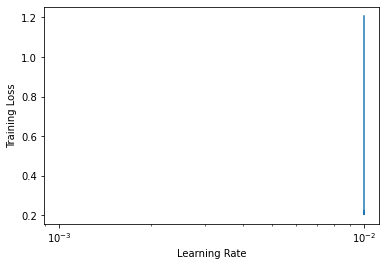

In [ ]:
#%%script false --no-raise-error
# Plot Learning Rate vs. Loss
plt.semilogx(history.history['lr'], history.history['loss'])
#plt.axis([1e-1, 2e-2, 0, 2])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
%%script false --no-raise-error
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=./logs_model_LSTM --port=6009

# Print the classification accuracy metrics

#### Print the Accuracy Test Scores

In [ ]:
#%%script false --no-raise-error
get_evaluation_accuracy(best_model, X_test_Glove, y_test)

Evaluation Accuracy: 0.882
Evaluation Loss: 0.450


####Print the average Accuracy, loss values from Training & Validation Datasets for comparison

In [ ]:
#%%script false --no-raise-error
print_values(history)

Mean Accuracy for the validation dataset: 
0.8372015216771294
Mean Loss for the validation dataset: 
0.5667102152810377
Mean Accuracy for the training dataset: 
0.8577045763240141
Mean Loss for the training dataset: 
0.4572651806999655



### Plot the Test & Training Loss

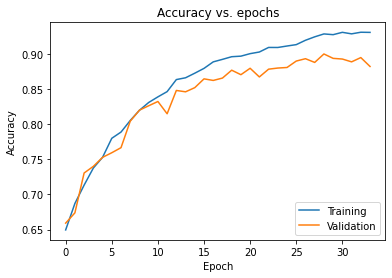

In [ ]:
#%%script false --no-raise-error
plot_accuracy(history)


### Plot the Test & Training Loss

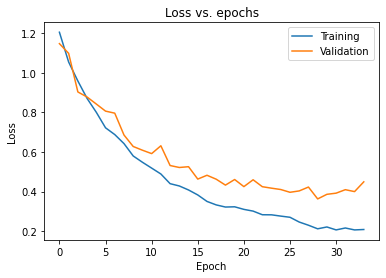

In [ ]:
#%%script false --no-raise-error
plot_loss(history)

In [ ]:
#%%script false --no-raise-error
print_scores(best_model, X_test_Glove, y_test)

Precision: 0.887594
Recall: 0.881825
F1 score: 0.877918
--------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#%%script false --no-raise-error
print_classification_report(best_model, X_test_Glove, y_test)

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.56      0.68       599
           1       0.86      0.78      0.82        46
           2       0.88      0.95      0.92       390
           3       0.84      0.94      0.89       309
           4       0.92      0.95      0.93       148
           5       0.79      0.48      0.60       116
           6       0.92      0.83      0.87       162
           7       0.93      0.98      0.95       101
           8       0.76      0.91      0.83       559
           9       0.94      0.66      0.78       151
          10       0.89      0.97      0.93       135
          11       0.95      0.93      0.94        44
          12       0.94      0.93      0.94       382
          13       0.93      0.96      0.94       227
          14       0.91      0.92      0.92       176
          15       0.83      0.91      0.87        54
          16       0.89      0.96      0.93       142
   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


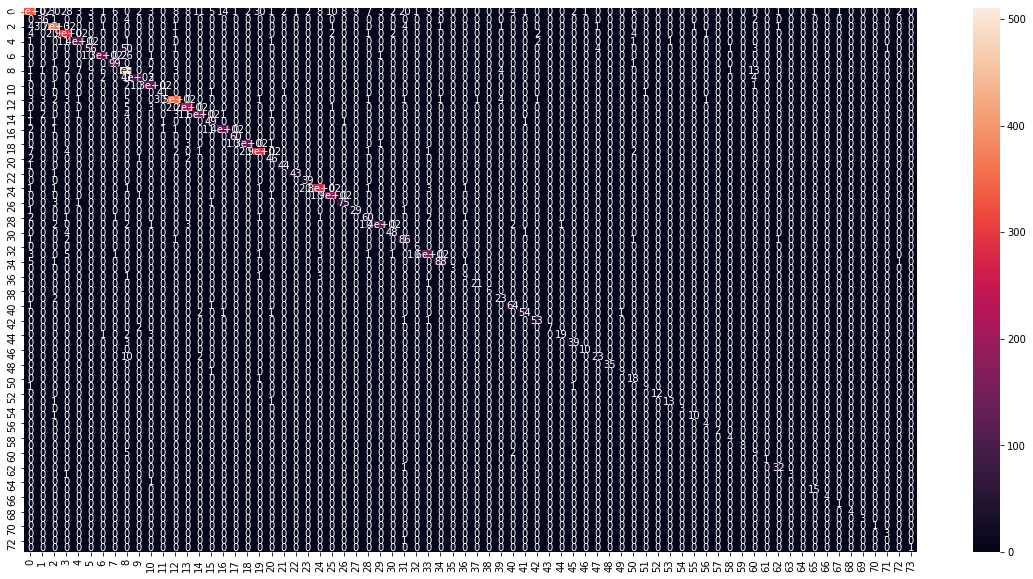

In [ ]:
#%%script false --no-raise-error
print_confusion_matrix(best_model, X_test_Glove, y_test)